In [1]:
import nltk
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
import json
import glob
import errno
import pandas
import random

In [2]:
# FUNCTIONS

# input: text (string) 
# output: average sentiment of the text and a list containing a tuple of each sentence with its corresponding sentiment
# sentiment is rating between -4 (VERY negative) and 4 (VERY positive)
def calcSentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    sentence_list = nltk.sent_tokenize(text)
    text_sentiment_avg, sentiment_paragraph_list =  0.0, [["", ""],["", ""]] # *** potential problems with empty sentiment_paragraph_lists

    if len(sentence_list) == 0:
        return text_sentiment_avg, sentiment_paragraph_list
        #raise ValueError('no sentences in the text given -> 0/0')

    sentiment_list = []
    sentence_sentiments = 0.0
    for sentence in sentence_list:
            vs = analyzer.polarity_scores(sentence)
            compound_sentiment = round(vs["compound"]*4, 4)
            sentiment_list = sentiment_list + [compound_sentiment]
            sentence_sentiments += compound_sentiment

    sentiment_paragraph_list = list(zip(sentence_list, sentiment_list))
    text_sentiment_avg = sentence_sentiments / len(sentence_list)

    return text_sentiment_avg, sentiment_paragraph_list

def get_json_text(json_file):
    json_string = json_file.read()
    json_dict = json.loads(json_string)
    return json_dict["text"]

# string split into paragraphs
def split_paragraphs(article_text):
    paragraph_list = article_text.split("\n")
    paragraph_list = [paragraph.strip(' ') for paragraph in paragraph_list]
    paragraph_list = list(filter(None, paragraph_list))
    return paragraph_list

def paragraph_analysis(paragraph_list):
    para_sentiments_list = []
    modified_paragraph_list = []
    for paragraph in paragraph_list:
        para_sentiment, modified_paragraph = calcSentiment(paragraph)
        para_sentiments_list = para_sentiments_list + [para_sentiment]
        modified_paragraph_list = modified_paragraph_list + [modified_paragraph]
    return para_sentiments_list, modified_paragraph_list

def json_file_analysis(path):
    files = glob.glob(path)
    article_sentiment_tot_list = []
    sentence_sentiment_list = [] 
    for file_name in files:
        try:
            with open(file_name, 'r') as json_file:
                article_text = get_json_text(json_file)
                paragraph_list = split_paragraphs(article_text)
                para_sentiments_list, modified_paragraph_list = paragraph_analysis(paragraph_list)  # analysis of paragraph sentiment 
                article_sentiment_tot, modified_tot = calcSentiment(article_text)   # total article sentiment (from all sentences)
                     
                sentence_list, sentiment_list = zip(*modified_tot)
                sentence_sentiment_list = sentence_sentiment_list + [sentiment_list]
                article_sentiment_tot_list = article_sentiment_tot_list + [article_sentiment_tot]
                
        except IOError as exc:
            if exc.errno != errno.EISDIR:
                raise

    return article_sentiment_tot_list, sentence_sentiment_list

def article_list_analysis(art_list):
    article_sentiment_tot_list = []
    sentence_sentiment_list = [] 

    for article_text in art_list:
        article_text = str(article_text)
        paragraph_list = split_paragraphs(article_text)
        para_sentiments_list, modified_paragraph_list = paragraph_analysis(paragraph_list)  # analysis of paragraph sentiment 
        article_sentiment_tot, modified_tot = calcSentiment(article_text)   # total article sentiment (from all sentences)

        sentence_list, sentiment_list = zip(*modified_tot)
        sentence_sentiment_list = sentence_sentiment_list + [sentiment_list]
        article_sentiment_tot_list = article_sentiment_tot_list + [article_sentiment_tot]

    return article_sentiment_tot_list, sentence_sentiment_list

def csv_file_analysis(path):
    df = pandas.read_csv(path)
    article_list = df['text'].values.tolist()
    art_sub_list = random.sample(article_list, 100)  # needed as 13000 takes too long
    article_sentiment_tot_list, sentence_sentiment_list = article_list_analysis(art_sub_list)
    return article_sentiment_tot_list, sentence_sentiment_list

def csv_file_analysis_kaggComp(path):
    df = pandas.read_csv(path)
    fake_df = df.loc[df['label'] == 1]
    real_df = df.loc[df['label'] == 0]
    article_list_fake = fake_df['text'].values.tolist()
    article_list_real = real_df['text'].values.tolist()
    article_list_fake = random.sample(article_list_fake, 100)  # needed as 13000 takes too long
    article_list_real = random.sample(article_list_real, 100)  # needed as 13000 takes too long
    article_sentiment_fake_list, sentence_sentiment_fake_list = article_list_analysis(article_list_fake)
    article_sentiment_real_list, sentence_sentiment_real_list = article_list_analysis(article_list_real)
    return article_sentiment_fake_list, sentence_sentiment_fake_list, article_sentiment_real_list, sentence_sentiment_real_list

In [3]:
# ANALYSIS

# FakeNewsNet data set
buzz_fake_news_path = 'C:\\Users\\orion\\Documents\\Python programming\\Sentiment Analysis\\FakeNewsNet-master\\Data\\BuzzFeed\\FakeNewsContent\\*.json'
buzz_fact_news_path = 'C:\\Users\\orion\\Documents\\Python programming\\Sentiment Analysis\\FakeNewsNet-master\\Data\\BuzzFeed\\RealNewsContent\\*.json'
poli_fake_news_path = 'C:\\Users\\orion\\Documents\\Python programming\\Sentiment Analysis\\FakeNewsNet-master\\Data\\PolitiFact\\FakeNewsContent\\*.json'
poli_fact_news_path = 'C:\\Users\\orion\\Documents\\Python programming\\Sentiment Analysis\\FakeNewsNet-master\\Data\\PolitiFact\\RealNewsContent\\*.json'

buzz_fake_article_sentiments, buzz_fake_sentence_sentiments = json_file_analysis(buzz_fake_news_path)
buzz_real_article_sentiments, buzz_real_sentence_sentiments = json_file_analysis(buzz_fact_news_path)
poli_fake_article_sentiments, poli_fake_sentence_sentiments = json_file_analysis(poli_fake_news_path)
poli_real_article_sentiments, poli_real_sentence_sentiments = json_file_analysis(poli_fact_news_path)


# Kaggle fake data set
kagg_news_path = 'C:\\Users\\orion\\Documents\\Python programming\\Sentiment Analysis\\reliable-nonreliable-news-kaggle\\train.csv'

kagg_fake_article_sentiments, kagg_fake_sentence_sentiments, kagg_real_article_sentiments, kagg_real_sentence_sentiments = csv_file_analysis_kaggComp(kagg_news_path)
'''
kagg_fake_news_path = 'C:\\Users\\orion\\Documents\\Python programming\\Sentiment Analysis\\fake-news-kaggle\\fake.csv'

kagg_fake_article_sentiments, kagg_fake_sentence_sentiments = csv_file_analysis(kagg_fake_news_path)
'''

"\nkagg_fake_news_path = 'C:\\Users\\orion\\Documents\\Python programming\\Sentiment Analysis\\fake-news-kaggle\\fake.csv'\n\nkagg_fake_article_sentiments, kagg_fake_sentence_sentiments = csv_file_analysis(kagg_fake_news_path)\n"

In [4]:
# mean and varience calculations
# make function calc_mean and calc_var?
buzz_fake_article_sentiments = np.asarray(buzz_fake_article_sentiments)
buzz_real_article_sentiments = np.asarray(buzz_real_article_sentiments)

fake_art_avg_buzz = np.mean(buzz_fake_article_sentiments)
fake_art_var_buzz = np.var(buzz_fake_article_sentiments)
real_art_avg_buzz = np.mean(buzz_real_article_sentiments)
real_art_var_buzz = np.var(buzz_real_article_sentiments)

print("fake article avg (buzz): " + str(fake_art_avg_buzz))
print("fake article var (buzz): " + str(fake_art_var_buzz))
print("real article avg (buzz): " + str(real_art_avg_buzz))
print("real article var (buzz): " + str(real_art_var_buzz))



poli_fake_article_sentiments = np.asarray(poli_fake_article_sentiments)
poli_real_article_sentiments = np.asarray(poli_real_article_sentiments)

fake_art_avg_poli = np.mean(poli_fake_article_sentiments)
fake_art_var_poli = np.var(poli_fake_article_sentiments)
real_art_avg_poli = np.mean(poli_real_article_sentiments)
real_art_var_poli = np.var(poli_real_article_sentiments)

print("fake article avg (poli): " + str(fake_art_avg_poli))
print("fake article var (poli): " + str(fake_art_var_poli))
print("real article avg (poli): " + str(real_art_avg_poli))
print("real article var (poli): " + str(real_art_var_poli))



kagg_fake_article_sentiments = np.asarray(kagg_fake_article_sentiments)
kagg_real_article_sentiments = np.asarray(kagg_real_article_sentiments)

fake_art_avg_kagg = np.mean(kagg_fake_article_sentiments)
fake_art_var_kagg = np.var(kagg_fake_article_sentiments)
real_art_avg_kagg = np.mean(kagg_real_article_sentiments)
real_art_var_kagg = np.var(kagg_real_article_sentiments)

print("fake article avg (kagg): " + str(fake_art_avg_kagg))
print("fake article var (kagg): " + str(fake_art_var_kagg))
print("real article avg (kagg): " + str(real_art_avg_kagg))
print("real article var (kagg): " + str(real_art_var_kagg))

fake article avg (buzz): -0.2733841413330502
fake article var (buzz): 0.47240008888592006
real article avg (buzz): -0.05390506089035616
real article var (buzz): 0.4716315766659883
fake article avg (poli): -0.050218263573281595
fake article var (poli): 0.6847500749677439
real article avg (poli): -0.08721103588369641
real article var (poli): 0.5439294907622266
fake article avg (kagg): -0.10062933177234275
fake article var (kagg): 0.7513278365391008
real article avg (kagg): 0.003128298714772955
real article var (kagg): 0.369407003406908


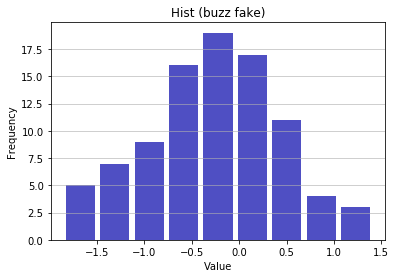

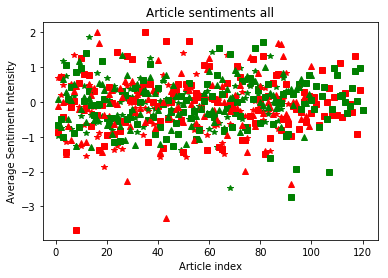

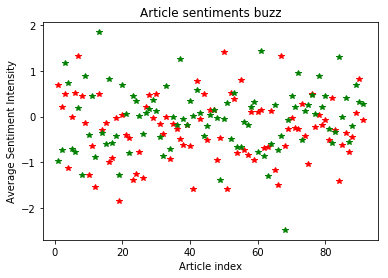

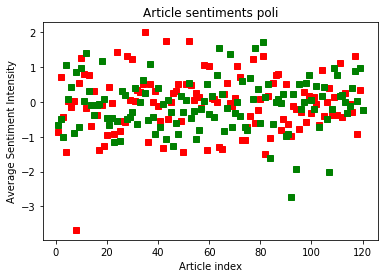

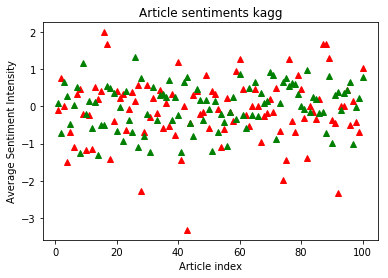

In [5]:
# plot of sentiment for each article
plt.hist(buzz_fake_article_sentiments, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Hist (buzz fake)')

plt.figure("Article sentiments all")
plt.plot(np.arange(1, len(buzz_fake_article_sentiments)+1), buzz_fake_article_sentiments, 'r*')
plt.plot(np.arange(1, len(buzz_real_article_sentiments)+1), buzz_real_article_sentiments, 'g*')
plt.plot(np.arange(1, len(poli_fake_article_sentiments)+1), poli_fake_article_sentiments, 'rs')
plt.plot(np.arange(1, len(poli_real_article_sentiments)+1), poli_real_article_sentiments, 'gs')
plt.plot(np.arange(1, len(kagg_fake_article_sentiments)+1), kagg_fake_article_sentiments, 'r^')
plt.plot(np.arange(1, len(kagg_real_article_sentiments)+1), kagg_real_article_sentiments, 'g^')
plt.title('Article sentiments all')
plt.xlabel('Article index')
plt.ylabel('Average Sentiment Intensity')

plt.figure("Article sentiments buzz")
plt.plot(np.arange(1, len(buzz_fake_article_sentiments)+1), buzz_fake_article_sentiments, 'r*')
plt.plot(np.arange(1, len(buzz_real_article_sentiments)+1), buzz_real_article_sentiments, 'g*')
plt.title('Article sentiments buzz')
plt.xlabel('Article index')
plt.ylabel('Average Sentiment Intensity')

plt.figure("Article sentiments poli")
plt.plot(np.arange(1, len(poli_fake_article_sentiments)+1), poli_fake_article_sentiments, 'rs')
plt.plot(np.arange(1, len(poli_real_article_sentiments)+1), poli_real_article_sentiments, 'gs')
plt.title('Article sentiments poli')
plt.xlabel('Article index')
plt.ylabel('Average Sentiment Intensity')

plt.figure("Article sentiments kagg")
plt.plot(np.arange(1, len(kagg_fake_article_sentiments)+1), kagg_fake_article_sentiments, 'r^')
plt.plot(np.arange(1, len(kagg_real_article_sentiments)+1), kagg_real_article_sentiments, 'g^')
plt.title('Article sentiments kagg')
plt.xlabel('Article index')
plt.ylabel('Average Sentiment Intensity')

'''
# plot of sentiment for each sentence
plt.figure("Senctence sentiments")
fake_flat_list = [item for sublist in buzz_fake_sentence_sentiments for item in sublist]
real_flat_list = [item for sublist in buzz_real_sentence_sentiments for item in sublist]
plt.plot(np.arange(1, len(fake_flat_list)+1), fake_flat_list, '-r')
plt.figure()
plt.plot(np.arange(1, len(real_flat_list)+1), real_flat_list, '-g')
plt.xlabel('Sentence index')
plt.ylabel('Average Sentiment Intensity')

plt.figure("Article sentiments kagg")
plt.plot(np.arange(1, len(kagg_fake_article_sentiments)+1), kagg_fake_article_sentiments, '-r*')
plt.title('Article sentiments kagg')
plt.xlabel('Article index')
plt.ylabel('Average Sentiment Intensity')
'''

plt.show()